# Run simulations 

In [37]:
import argparse
from functools import partial
import json
import os
import pickle
import random
import sys

from pydantic import BaseModel

current_path = sys.path[0]
sys.path.append(
    current_path[: current_path.find("defi-measurement")]
    + "liquidity-distribution-history"
)

sys.path.append("..")

from datetime import datetime
from typing import Tuple, cast
from prisma import Client
import asyncio


from math import ceil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from matplotlib.ticker import MaxNLocator
from pool_state import v3Pool
from sqlalchemy import create_engine
from tqdm import tqdm, trange
from multiprocessing import Pool
from azure.storage.blob import BlobServiceClient


load_dotenv(override=True)


from decimal import ROUND_DOWN, Decimal, getcontext

getcontext().prec = 100  # Set the precision high enough for our purposes

import pandera as pa
from pandera.typing import DataFrame, Series

from web3 import Web3



# Read in the environment variables
postgres_uri = os.environ["POSTGRESQL_URI_US"]
blobstorage_uri = os.environ["AZURE_STORAGE_CONNECTION_STRING"]

## Get data and define functions

In [46]:
def run_simulation(pool: v3Pool, swaps_parameters: list, pbar=True) -> np.ndarray:
    """
    swaps_parameters: list of dicts with the following keys:
        - input: amount of token0 to swap in
        - tokenIn: address of token being swapped in
        - as_of: block number to simulate the swap at
        - gasFee: boolean indicating whether to include gas fees in the swap
    """

    # Get the sqrtPriceX96 at the start of the block
    sqrtPrice_next = pool.getPriceAt(swaps_parameters[0]["as_of"])

    prices = np.zeros(len(swaps_parameters) + 1, dtype=np.float64)

    for i, s in tqdm(enumerate(swaps_parameters, start=0), disable=not pbar):
        s["givenPrice"] = sqrtPrice_next
        _, heur = pool.swapIn(s, fees=True)
        sqrtPrice_next = heur.sqrtP_next
        prices[i] = 1 / (heur.sqrt_P**2 / 1e12)

    # Calculate the price at the end of the block
    prices[-1] = 1 / (sqrtPrice_next**2 / 1e12)

    return prices


In [41]:
# Create the database engine
engine = create_engine(postgres_uri)

# Get a dataframe of blocks that has enough buys and sells
block_number = 13784918
address = "0x3782a3425cd093d5cd0c5b684be72641e199029c"

df1 = pd.read_sql(
    f"""
    SELECT *
    FROM SWAPS
    WHERE BLOCK_NUMBER = {block_number}
        AND ADDRESS = '{address}'
    """,
    engine,
)

df1.head()

,block_ts,block_number,tx_hash,log_index,sender,recipient,amount0,amount1,sqrtpricex96,liquidity,tick,address,to_address,from_address,transaction_index
0,2021-12-11 16:25:20,13784918,0x1e56f6a9156a149ce02515cee89dc90c2cde9ecbee84...,560,0xe592427a0aece92de3edee1f18e0157c05861564,0xe592427a0aece92de3edee1f18e0157c05861564,10000000000000000000,-387195291779019342,15663923772010702948645558912,3361909994543544846090,-32422,0x3782a3425cd093d5cd0c5b684be72641e199029c,0x1fa5cada1bb1216ba9f17c194a72d7b357022e21,0xe592427a0aece92de3edee1f18e0157c05861564,320
1,2021-12-11 16:25:20,13784918,0x958ed091b4d49d75fff03eef9ed49b18ce39e57de37c...,18,0xe592427a0aece92de3edee1f18e0157c05861564,0xe592427a0aece92de3edee1f18e0157c05861564,315544042577612679694,-11603928985465258289,15100469051237251196561566233,2698879270619254794715,-33154,0x3782a3425cd093d5cd0c5b684be72641e199029c,0x68c924273a3a72165c2a60e559dd0f5267583f75,0xe592427a0aece92de3edee1f18e0157c05861564,3
2,2021-12-11 16:25:20,13784918,0xac5a429f17efae4fbac683c1e5a403c6bdbc9f101497...,487,0xe592427a0aece92de3edee1f18e0157c05861564,0xb9f3800eeb6d6dfda14f370822ca30504cafaac6,-5000000000000000000,196745727585803685,15639705671429659455204659286,3361909994543544846090,-32453,0x3782a3425cd093d5cd0c5b684be72641e199029c,0xb9f3800eeb6d6dfda14f370822ca30504cafaac6,0xe592427a0aece92de3edee1f18e0157c05861564,271
3,2021-12-11 16:25:20,13784918,0x7df8eb0352efb394ad8c2c79eeafb982c2d52b3daa38...,385,0xe592427a0aece92de3edee1f18e0157c05861564,0x27630d4649b410470948487abac9a5661fe20250,-25000000000000000000,975918998768191336,15586604077422936366641064288,3361909994543544846090,-32521,0x3782a3425cd093d5cd0c5b684be72641e199029c,0x27630d4649b410470948487abac9a5661fe20250,0xe592427a0aece92de3edee1f18e0157c05861564,207
4,2021-12-11 16:25:20,13784918,0x1048032e2feea7619488343130e67e7dbe9ec774203b...,463,0xe592427a0aece92de3edee1f18e0157c05861564,0xe592427a0aece92de3edee1f18e0157c05861564,4917838572076474818,-189271739222671422,15619090272412843047101163377,3361909994543544846090,-32479,0x3782a3425cd093d5cd0c5b684be72641e199029c,0x2bc937aa37705d10385b373d91e5bbe2d684aadf,0xe592427a0aece92de3edee1f18e0157c05861564,254


In [233]:
# Query the `token_info` table to get the token symbols
token_info = pd.read_sql(
    f"""
    SELECT *
    FROM TOKEN_INFO
    WHERE pool = '{address}'
    """,
    engine,
)

pool_name = f"{token_info['token0symbol'][0]}-{token_info['token1symbol'][0]}-{int(token_info['fee'][0]) / 1e4}%" # type: ignore
pool_name

'BYTES-WETH-1.0%'

In [19]:
df2 = pd.read_gbq(
    """
    SELECT * FROM `bigquery-public-data.crypto_ethereum.transactions`
    WHERE `block_number` = 13784918
    """,
    project_id="mimetic-design-338620",
    dialect="standard",
)

df2.shape

(404, 21)

In [20]:
df2.head()

,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,input,receipt_cumulative_gas_used,...,receipt_contract_address,receipt_root,receipt_status,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price
0,0x43391042d4d64037b046753deed9e9f76ef5de4a7104...,973739,74,0xc098b2a3aa256d2140208c3de6543aaef5cd3a94,0xecd480d8b8fe2654bfc964ecb66e3cc63e73cbff,343101830000000000.000000000,63000,255534681099,0x,5989927,...,None,None,1,2021-12-11 16:25:20+00:00,13784918,0x4f957d4673c55a9ba044c3d68883aa077bc0d8ba13f4...,1000000000000,19380000000,2,255534681099
1,0x9cbd441e2098590a10e1487f13a751f6be588a9ac72a...,159507,60,0x7abe0ce388281d2acf297cb089caef3819b13448,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0E-9,76564,267429681099,0xa9059cbb000000000000000000000000c7bfd896cc6a...,5381836,...,None,None,1,2021-12-11 16:25:20+00:00,13784918,0x4f957d4673c55a9ba044c3d68883aa077bc0d8ba13f4...,1131000000000,31275000000,2,267429681099
2,0x1a3d81178a5f4f56dcfb462d18480ed3594b5ede257d...,277,89,0x4b6379799642fe236fa3e0a870034fbcac3bfa28,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0E-9,170941,246154681099,0x4a25d94a000000000000000000000000000000000000...,6796851,...,None,None,1,2021-12-11 16:25:20+00:00,13784918,0x4f957d4673c55a9ba044c3d68883aa077bc0d8ba13f4...,400000000000,10000000000,2,246154681099
3,0x2208a50997df96c948251997ede060b8ad2cc466efad...,973741,76,0xc098b2a3aa256d2140208c3de6543aaef5cd3a94,0x8c0fd328e22055984f268976d961f5ceb2073a51,245000000000000000.000000000,110235,255534681099,0x,6047672,...,None,None,1,2021-12-11 16:25:20+00:00,13784918,0x4f957d4673c55a9ba044c3d68883aa077bc0d8ba13f4...,1000000000000,19380000000,2,255534681099
4,0xf1cd630dff41a91a71e51e74e067747a02f29d380356...,140,183,0x81b61cc8752d08e6b66a5a2c4caeb3b6ed9bbe8a,0x1111111254fb6c44bac0bed2854e76f90643097d,0E-9,262909,237804681099,0xe449022e000000000000000000000000000000000000...,13959004,...,None,None,1,2021-12-11 16:25:20+00:00,13784918,0x4f957d4673c55a9ba044c3d68883aa077bc0d8ba13f4...,284060135957,1650000000,2,237804681099


In [80]:
# Join the two dataframes on the `tx_hash` in df and the `hash` in df2
df = df1.merge(df2, left_on="tx_hash", right_on="hash", how="left", suffixes=("", "_y"))

df.columns

Index(['block_ts', 'block_number', 'tx_hash', 'log_index', 'sender',
       'recipient', 'amount0', 'amount1', 'sqrtpricex96', 'liquidity', 'tick',
       'address', 'to_address', 'from_address', 'transaction_index', 'hash',
       'nonce', 'transaction_index_y', 'from_address_y', 'to_address_y',
       'value', 'gas', 'gas_price', 'input', 'receipt_cumulative_gas_used',
       'receipt_gas_used', 'receipt_contract_address', 'receipt_root',
       'receipt_status', 'block_timestamp', 'block_number_y', 'block_hash',
       'max_fee_per_gas', 'max_priority_fee_per_gas', 'transaction_type',
       'receipt_effective_gas_price'],
      dtype='object')

In [82]:
# Keep only the columns we need
df = df[
    [
        "block_number",
        "tx_hash",
        "transaction_index",
        "log_index",
        "sender",
        "amount0",
        "amount1",
        "gas_price",
    ]
].set_index(["transaction_index", "log_index"])

df.head()

,,block_number,tx_hash,sender,amount0,amount1,gas_price
transaction_index,log_index,,,,,,
320,560,13784918,0x1e56f6a9156a149ce02515cee89dc90c2cde9ecbee84...,0xe592427a0aece92de3edee1f18e0157c05861564,10000000000000000000,-387195291779019342,237654681099
3,18,13784918,0x958ed091b4d49d75fff03eef9ed49b18ce39e57de37c...,0xe592427a0aece92de3edee1f18e0157c05861564,315544042577612679694,-11603928985465258289,237654681099
271,487,13784918,0xac5a429f17efae4fbac683c1e5a403c6bdbc9f101497...,0xe592427a0aece92de3edee1f18e0157c05861564,-5000000000000000000,196745727585803685,237654681099
207,385,13784918,0x7df8eb0352efb394ad8c2c79eeafb982c2d52b3daa38...,0xe592427a0aece92de3edee1f18e0157c05861564,-25000000000000000000,975918998768191336,237654681099
254,463,13784918,0x1048032e2feea7619488343130e67e7dbe9ec774203b...,0xe592427a0aece92de3edee1f18e0157c05861564,4917838572076474818,-189271739222671422,237654681099


In [83]:
# Convert amount0 and amount1 to floats
df["amount0"] = df["amount0"].astype(float)
df["amount1"] = df["amount1"].astype(float)

# Convert gas_price to float
df["gas_price"] = df["gas_price"].astype(float)

# Add column for buy/sell
df["direction"] = np.where(df.amount0 > 0, "buy", "sell") # type: ignore

df.head()   

,,block_number,tx_hash,sender,amount0,amount1,gas_price,direction
transaction_index,log_index,,,,,,,
320,560,13784918,0x1e56f6a9156a149ce02515cee89dc90c2cde9ecbee84...,0xe592427a0aece92de3edee1f18e0157c05861564,1.000000e+19,-3.871953e+17,2.376547e+11,buy
3,18,13784918,0x958ed091b4d49d75fff03eef9ed49b18ce39e57de37c...,0xe592427a0aece92de3edee1f18e0157c05861564,3.155440e+20,-1.160393e+19,2.376547e+11,buy
271,487,13784918,0xac5a429f17efae4fbac683c1e5a403c6bdbc9f101497...,0xe592427a0aece92de3edee1f18e0157c05861564,-5.000000e+18,1.967457e+17,2.376547e+11,sell
207,385,13784918,0x7df8eb0352efb394ad8c2c79eeafb982c2d52b3daa38...,0xe592427a0aece92de3edee1f18e0157c05861564,-2.500000e+19,9.759190e+17,2.376547e+11,sell
254,463,13784918,0x1048032e2feea7619488343130e67e7dbe9ec774203b...,0xe592427a0aece92de3edee1f18e0157c05861564,4.917839e+18,-1.892717e+17,2.376547e+11,buy


In [84]:
# Create pool object
from experiments.random_permutations import load_pool


pool = load_pool(
    pool_address=address,
    postgres_uri=postgres_uri,
)

Loading pool from cache


In [136]:
senders = df.sender.unique()
senders_dict = {s: chr(65 + i) for i, s in enumerate(senders)}

In [222]:
def run_sequence(pool: v3Pool, df: pd.DataFrame, senders_dict: dict, ax=None) -> tuple[pd.DataFrame, list, list]:

    # Run the baseline simulation
    swaps_parameters = [
        {
            "input": row["amount0"],
            "tokenIn": pool.token0,
            "as_of": row["block_number"],
            "gasFee": True,
        }
        for _, row in df.iterrows()
    ]

    prices = run_simulation(pool, swaps_parameters)

    # Plot the prices
    # x-ticks for every swap
    if ax is None:
        _, ax = plt.subplots(figsize=(16, 8))

    fig = ax.figure

    ax.plot(range(len(prices)), prices, label="Price")
    ax.set_title("Price Curve within a Block")
    ax.set_xlabel("Swap Number")
    ax.set_ylabel("Price")
    ax.grid()

    # Have tick labels for every swap
    ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=len(prices)))
    ax.set_xlim(0, len(prices) - 1)

    # Add labels for buy/sell
    for i, row in df.reset_index(drop=True).iterrows():
        if row["direction"] == "buy":
            ax.axvline(i, color="green", alpha=0.3) # type: ignore
        else:
            ax.axvline(i, color="red", alpha=0.3) # type: ignore

    # Add labels sender
    for i, row in df.reset_index(drop=True).iterrows():
        ax.text(
            i, # type: ignore
            prices[i], # type: ignore
            senders_dict[row["sender"]],
            rotation=0,
            verticalalignment="bottom",
            horizontalalignment="left",
            fontsize=14,
            alpha=0.75,
        )

    # Add a horzonital line at the initial price
    ax.axhline(prices[0], color="purple", alpha=0.75, label="Initial Price", ls="--")

    # Add the transaction sizes as a bar chart on the bottom of the plot
    ax2 = ax.twinx()
    ax2.bar(
        range(len(prices) - 1),
        df["amount0"].abs(),
        color="black",
        alpha=0.3,
        width=0.5,
        align="edge",
        label="Swap Size",
    )
    ax2.set_ylabel("Transaction Size", color="black")
    ax2.set_ylim(0, 2 * df["amount0"].abs().max().item())

    # Calculate the absolute area between the price curve and the initial price
    area = np.trapz(np.abs(prices - prices[0]))

    # Shade in the area between the initial price and the price curve
    ax.fill_between(
        range(len(prices)),
        prices[0],
        prices,
        where=prices > prices[0],
        facecolor="green",
        alpha=0.1,
        interpolate=True,
        label=f"Area: {area:.2e}",        
    )
    ax.fill_between(
        range(len(prices)),
        prices[0],
        prices,
        where=prices < prices[0],
        facecolor="green",
        alpha=0.1,
        interpolate=True,
    )

    # Add a line for the maximum deviation from the initial price in absolute terms
    max_dev = prices[np.argmax(np.abs(prices - prices[0]))]
    ax.axhline(
        max_dev,
        color="black",
        alpha=0.75,
        label=f"Max Deviation: {(max_dev - prices[0]) / prices[0]:.2%}",
        ls="--",
    )

    # Add the relative standard deviation of the price in the legend
    ax.axhline(
        prices.std() + prices[0],
        color="red",
        alpha=0.75,
        label=f"Std Dev: {prices.std() / prices.mean():.2%}",
        ls="-.",
    )

    # Add a legend in the plot in the top right
    # fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes)

    # Combine the legend handles from the two axes
    handles, labels = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles.extend(handles2)
    labels.extend(labels2)

    # Set the new handles and labels on the original axis object
    ax.legend(handles, labels, loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes)

    # Return a dataframe with the realized prices with the same index as df
    return pd.DataFrame(dict(prices=prices[1:], direction=df.direction), index=df.index), handles, labels

## Run simulations for the block as it was

44it [00:00, 64.59it/s]


,,prices,direction
transaction_index,log_index,,
320,560,2.588892e+13,buy
3,18,2.704830e+13,buy
271,487,2.702922e+13,sell
207,385,2.693395e+13,sell
254,463,2.695268e+13,buy


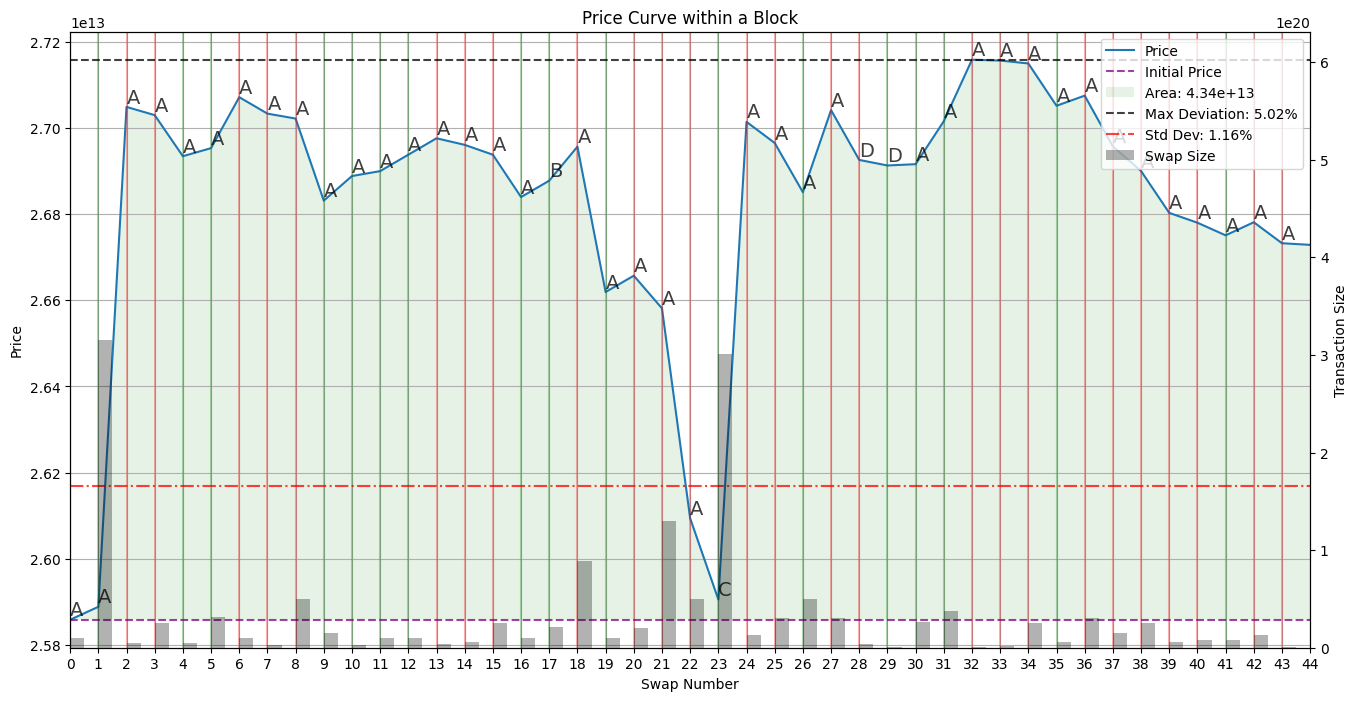

In [223]:
# Plot the original sequence
realized, _, _ = run_sequence(pool, df, senders_dict)

realized.head()

## Run simulations for a block with an implementation of the sequencing rule

In [178]:
from collections import deque


def sequencing_by_rule(df: pd.DataFrame) -> pd.DataFrame:
    delta_amount0 = 0
    sequence = []

    # Order by the gas price descending
    df = df.sort_values("gas_price", ascending=False)

    # Split into buys and sells
    buy_q = deque(df[df.direction == "buy"].index)
    sell_q = deque(df[df.direction == "sell"].index)

    # Add the buys and sells according to the rule
    while buy_q and sell_q:
        if delta_amount0 > 0:
            # Sell
            sequence.append(sell_q.popleft())
            delta_amount0 += df.loc[sequence[-1], "amount0"]
        else:
            # Buy
            sequence.append(buy_q.popleft())
            delta_amount0 += df.loc[sequence[-1], "amount0"]

    # Add the remaining buys and sells
    sequence.extend(list(buy_q) + list(sell_q))

    # Return the dataframe with the realized prices
    return df.loc[sequence]
    
sequenced_df = sequencing_by_rule(df)

44it [00:00, 67.37it/s]


,,prices,direction
transaction_index,log_index,,
175,309,2.586131e+13,buy
5,28,2.547537e+13,sell
183,335,2.553753e+13,buy
274,492,2.561533e+13,buy
1,8,2.576459e+13,buy


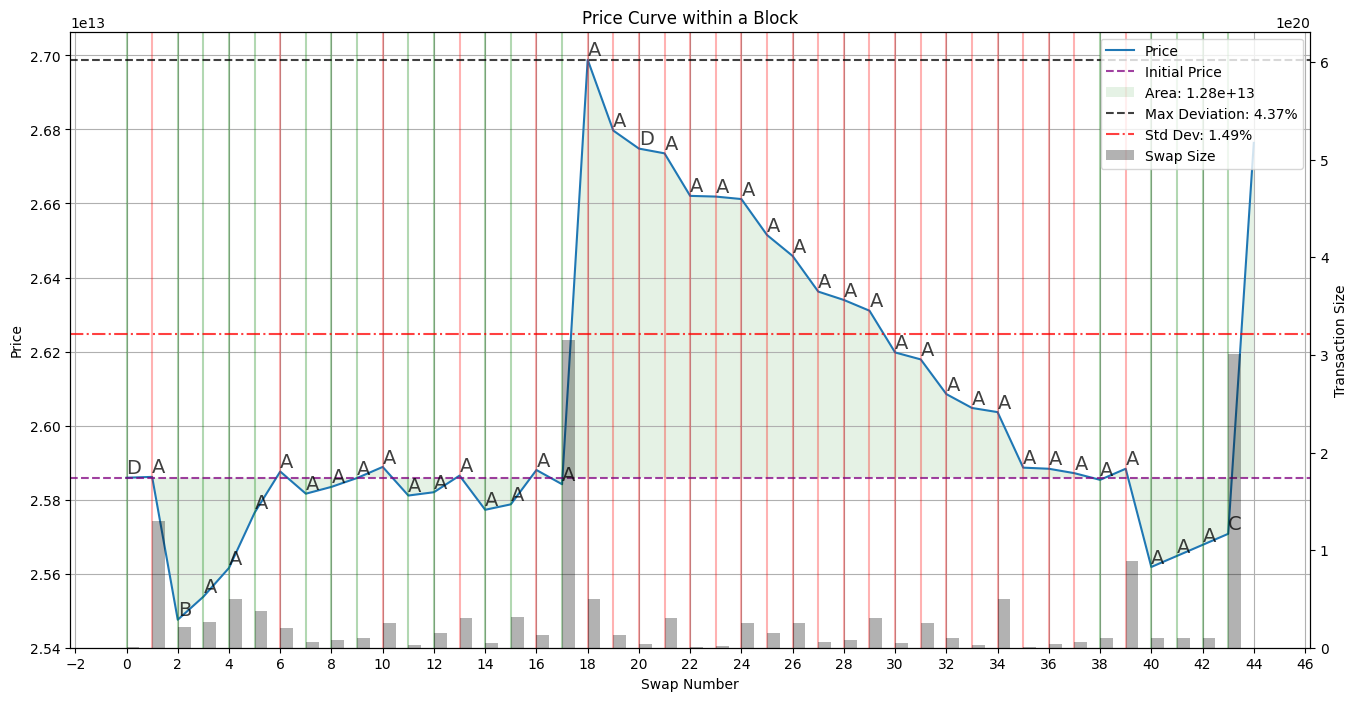

In [197]:
# Plot the original sequence
sequenced_realized, _, _ = run_sequence(pool, sequenced_df, senders_dict)

sequenced_realized.head()

## Compare the two plots


44it [00:00, 61.48it/s]
44it [00:00, 67.82it/s]


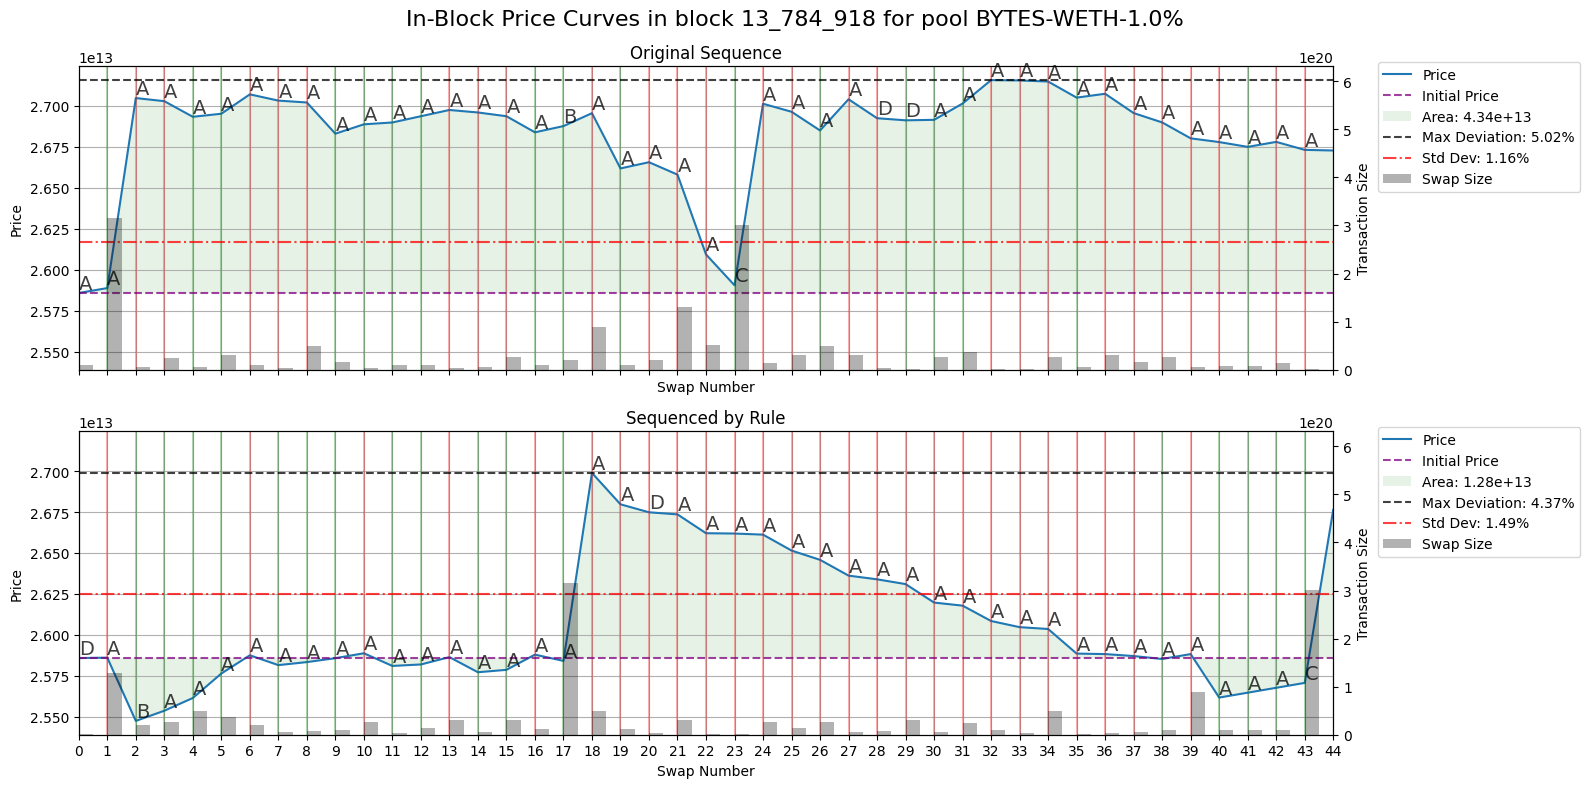

In [234]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), sharex=True, sharey=True)

_, handles1, labels1 = run_sequence(pool, df, senders_dict, ax=ax1)
_, handles2, labels2 = run_sequence(pool, sequenced_df, senders_dict, ax=ax2)

ax1.set_title("Original Sequence")
ax2.set_title("Sequenced by Rule")


# Place the legend underneath the plot laid out horizontally
ax1.legend(
    handles1,
    labels1,
    loc="center left",
    bbox_to_anchor=(1.03, 0.8),
    ncol=1
)

# Place the legend underneath the plot laid out horizontally
ax2.legend(
    handles2,
    labels2,
    loc="center left",
    bbox_to_anchor=(1.03, 0.8),
    ncol=1
)

# Set the super title
fig.suptitle(f"In-Block Price Curves in block {block_number:_} for pool {pool_name}", fontsize=16)

fig.tight_layout()

## Calculate the difference in price for each swap

In [159]:
diff_df = pd.concat(
    [
        realized.rename(columns={"prices": "actual"}).drop(columns="direction"),
        sequenced_realized.rename(columns={"prices": "sequenced"}),
    ],
    axis=1,
)

df_diff = diff_df.assign(directional_diff=np.where(df.direction.values == "sell", (diff_df.sequenced - diff_df.actual).values, diff_df.actual - diff_df.sequenced)) # type: ignore
df_diff = df_diff.assign(relative_diff=df_diff.directional_diff / df_diff.actual) # type: ignore

# Join with the senders from the original dataframe
df_diff = df_diff.join(df.sender)
df_diff.sender = df_diff.sender.map(senders_dict)

df_diff

,,actual,sequenced,direction,directional_diff,relative_diff,sender
transaction_index,log_index,,,,,,
320,560,2.588892e+13,2.588823e+13,buy,6.922080e+08,0.000027,A
3,18,2.704830e+13,2.698848e+13,buy,5.981622e+10,0.002211,A
271,487,2.702922e+13,2.617875e+13,sell,-8.504758e+11,-0.031465,A
207,385,2.693395e+13,2.608499e+13,sell,-8.489636e+11,-0.031520,A
254,463,2.695268e+13,2.578710e+13,buy,1.165579e+12,0.043245,A
354,609,2.707088e+13,2.587990e+13,buy,1.190983e+12,0.043995,A
374,636,2.703272e+13,2.604753e+13,sell,-9.851903e+11,-0.036444,A
18,75,2.702128e+13,2.603630e+13,sell,-9.849798e+11,-0.036452,A
290,514,2.683094e+13,2.588626e+13,sell,-9.446780e+11,-0.035209,A


Text(0.5, 0, 'Swap Number')

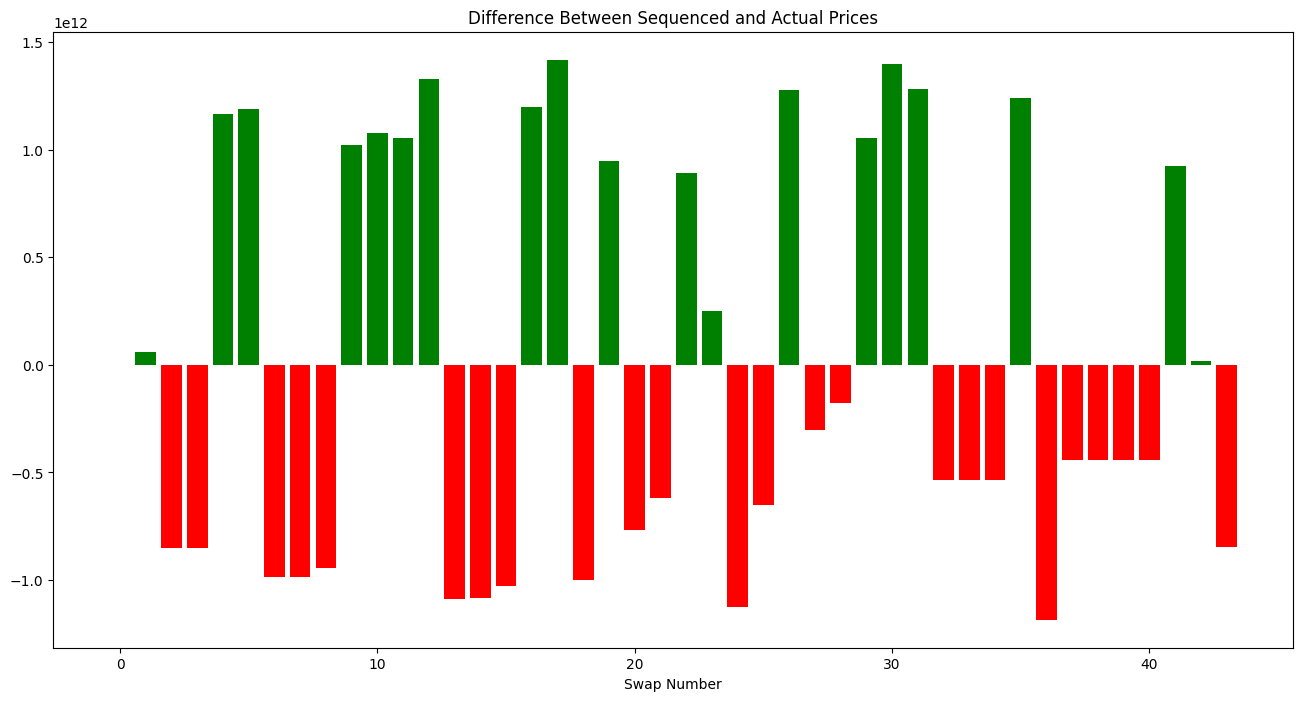

In [170]:
# What is the aggregate difference between the two sequences?
f"{df_diff.directional_diff.sum():.2e}, {df_diff.relative_diff.sum():.2%}"

# Plot the difference between the two sequences
fig, ax = plt.subplots(figsize=(16, 8))

# Make a bar chart for the difference between the two sequences where positive are green and negative are red
ax.bar(
    range(df_diff.shape[0]),
    df_diff.directional_diff,
    color=np.where(df_diff.directional_diff.values > 0, "green", "red"),
    label="Directional Difference",
)

ax.set_title("Difference Between Sequenced and Actual Prices")
ax.set_xlabel("Swap Number")

## Compare the welfare of the traders

In [235]:
# Aggregate the difference by sender and add a total row
trader_diff = df_diff.groupby("sender").agg(
    {
        "directional_diff": "sum",
        "relative_diff": "sum",
    }
)

trader_diff.loc["Total"] = trader_diff.sum()

trader_diff


,directional_diff,relative_diff
sender,,
A,-1.605270e+12,-0.060381
B,1.418573e+12,0.052625
C,2.498523e+11,0.009249
D,8.771886e+11,0.032590
Total,9.403437e+11,0.034083


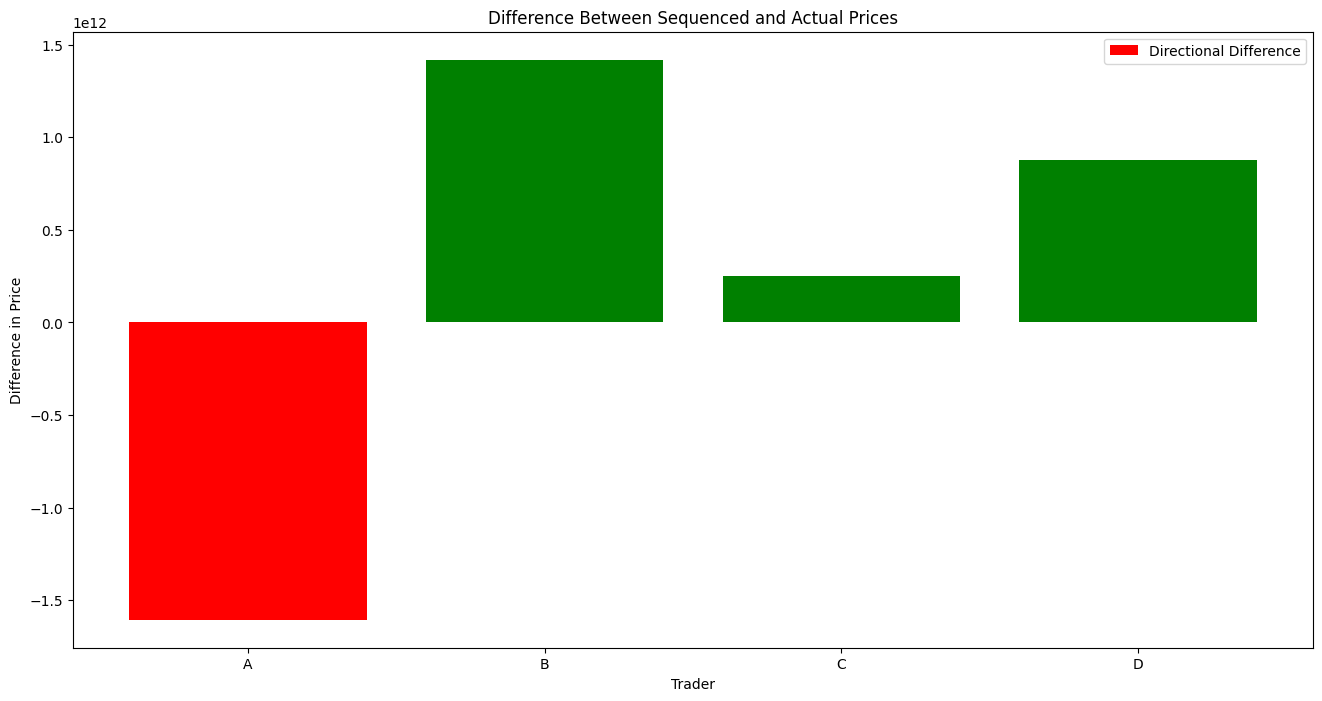

In [173]:
# Plot the results as a bar chart
fig, ax = plt.subplots(figsize=(16, 8))

# Make a bar chart for the difference between the two sequences where positive are green and negative are red
ax.bar(
    trader_diff.index,
    trader_diff.directional_diff,
    color=np.where(trader_diff.directional_diff.values > 0, "green", "red"),
    label="Directional Difference",
)

ax.set_title("Difference Between Sequenced and Actual Prices")
ax.set_xlabel("Trader")
ax.set_ylabel("Difference in Price")

# Add a legend
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes)